In [1]:
from chronos import ChronosPipeline
import torch
import pandas as pd
import matplotlib.pyplot as plt

d:\科研项目\TSFM_Finance\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_excess_ret = pd.read_csv('../data/two_stocks_excess_returns.csv', index_col=0, parse_dates=True)

num_samples = 20
prediction_length = 10
window_size = 21
input = torch.tensor(df_excess_ret.iloc[:window_size].values.T)

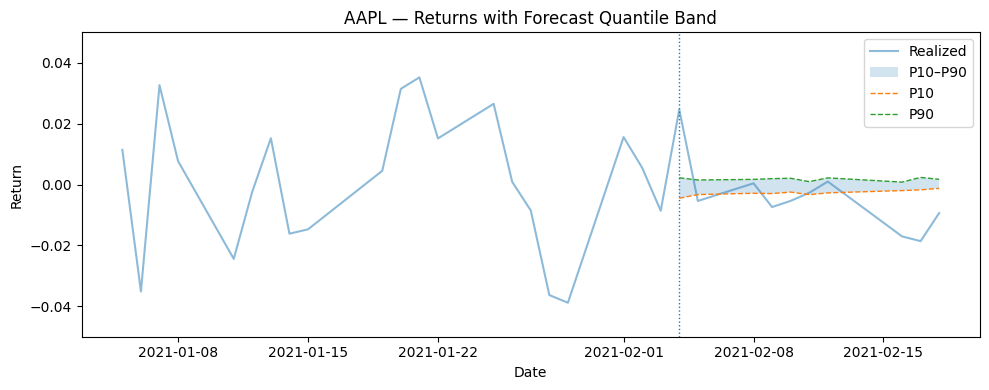

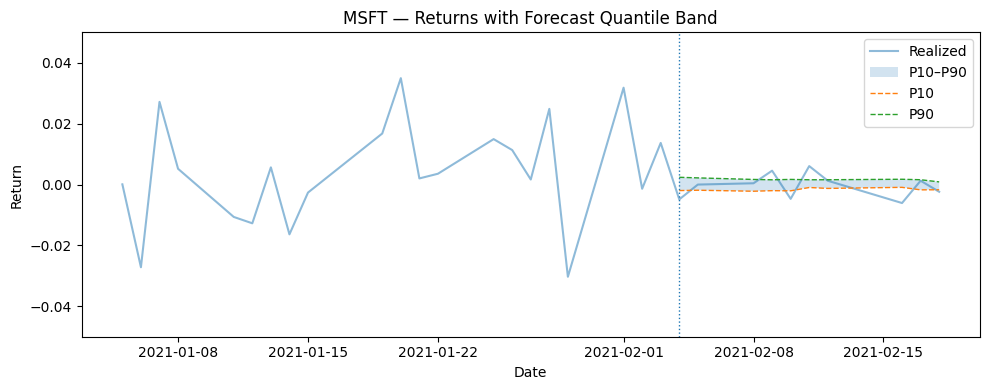

In [3]:
pipeline = ChronosPipeline.from_pretrained(
  "FinText/Chronos_Small_2022_Global",
  device_map="auto",
  dtype=torch.bfloat16,
)

out = pipeline.predict(
    input,
    prediction_length=prediction_length,  # predict all q steps in one call (internal AR)
    num_samples=num_samples
) 

mean = out.mean(axis = 1)
p90 = out.quantile(0.9, dim=1)
p10 = out.quantile(0.1, dim=1)

df_p90 = pd.DataFrame(p90.T, index=df_excess_ret.index[window_size : window_size + prediction_length], columns=df_excess_ret.columns)
df_p10 = pd.DataFrame(p10.T, index=df_excess_ret.index[window_size : window_size + prediction_length], columns=df_excess_ret.columns)

forecast_idx = df_p10.index

for col in df_excess_ret.columns:
    fig = plt.figure(figsize=(10, 4))
    ax = plt.gca()

    ax.plot(df_excess_ret.iloc[:window_size + prediction_length][col], label="Realized", alpha=0.5)

    y_low = df_p10[col].reindex(forecast_idx)
    y_high = df_p90[col].reindex(forecast_idx)


    mask = (~y_low.isna()) & (~y_high.isna())
    ax.fill_between(forecast_idx[mask], y_low[mask], y_high[mask], alpha=0.2, label="P10–P90")


    ax.plot(forecast_idx[mask], y_low[mask], linestyle="--", linewidth=1, label="P10")
    ax.plot(forecast_idx[mask], y_high[mask], linestyle="--", linewidth=1, label="P90")

    if len(forecast_idx) > 0:
        ax.axvline(forecast_idx[0], linestyle=":", linewidth=1)
    ax.set_ylim(-0.05, 0.05)
    ax.set_title(f"{col} — Returns with Forecast Quantile Band")
    ax.set_xlabel("Date")
    ax.set_ylabel("Return")
    ax.legend(loc="best")
    plt.tight_layout()
    plt.show()